<a href="https://colab.research.google.com/github/ubermenchh/fun/blob/main/textgen_pytorch_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import unidecode
import random
import torch

In [3]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-10-05 05:43:17--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2023-10-05 05:43:18 (24.3 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [4]:
text = open('input.txt', 'r').read()
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [62]:
text0 = list(text[:10000])
print(text0)

['F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '\n', '\n', 'A', 'l', 'l', ':', '\n', 'S', 'p', 'e', 'a', 'k', ',', ' ', 's', 'p', 'e', 'a', 'k', '.', '\n', '\n', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n', 'Y', 'o', 'u', ' ', 'a', 'r', 'e', ' ', 'a', 'l', 'l', ' ', 'r', 'e', 's', 'o', 'l', 'v', 'e', 'd', ' ', 'r', 'a', 't', 'h', 'e', 'r', ' ', 't', 'o', ' ', 'd', 'i', 'e', ' ', 't', 'h', 'a', 'n', ' ', 't', 'o', ' ', 'f', 'a', 'm', 'i', 's', 'h', '?', '\n', '\n', 'A', 'l', 'l', ':', '\n', 'R', 'e', 's', 'o', 'l', 'v', 'e', 'd', '.', ' ', 'r', 'e', 's', 'o', 'l', 'v', 'e', 'd', '.', '\n', '\n', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n', 'F', 'i', 'r', 's', 't', ',', ' ', '

In [63]:
def join_string(text):
    return ''.join(string for string in text)

text0 = join_string(text0)
len(text0.split())

1768

In [64]:
print(text0)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [65]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [66]:
len(nltk.corpus.stopwords.words('english'))

179

In [67]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [68]:
stop = set(nltk.corpus.stopwords.words('english'))
exclude = set(string.punctuation)
lemma = nltk.stem.wordnet.WordNetLemmatizer()

def clean(doc):
    stop_free = ' '.join([i for i in doc.split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = ' '.join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

test_sentence = clean(text0).lower().split()

In [69]:
len(test_sentence)

1154

In [70]:
trigrams = [([test_sentence[i], test_sentence[i+1]], test_sentence[i+2]) for i in range(len(test_sentence)-2)]
chunk_len = len(trigrams)
print(trigrams[:3])

[(['first', 'citizen'], 'before'), (['citizen', 'before'], 'proceed'), (['before', 'proceed'], 'further')]


In [71]:
sorted(list(set(test_sentence)))

['a',
 'abhorring',
 'abundance',
 'abundantly',
 'account',
 'accounted',
 'accusation',
 'accused',
 'accuser',
 'act',
 'affection',
 'afflicts',
 'affright',
 'against',
 'agent',
 'agrippa',
 'alack',
 'all',
 'almost',
 'already',
 'altitude',
 'always',
 'and',
 'anhungry',
 'another',
 'answer',
 'answerd',
 'appear',
 'appetite',
 'apply',
 'arm',
 'art',
 'as',
 'aside',
 'assembly',
 'asunder',
 'attends',
 'audit',
 'authority',
 'away',
 'awe',
 'awhile',
 'ay',
 'back',
 'bale',
 'barren',
 'basest',
 'bat',
 'battle',
 'bear',
 'bearing',
 'because',
 'become',
 'before',
 'belly',
 'below',
 'beneath',
 'benefit',
 'beseech',
 'bestow',
 'blood',
 'body',
 'bold',
 'brain',
 'bran',
 'bread',
 'break',
 'breath',
 'broke',
 'brutus',
 'business',
 'but',
 'caius',
 'calamity',
 'call',
 'came',
 'cannot',
 'cap',
 'capitol',
 'care',
 'cared',
 'chain',
 'change',
 'charitable',
 'chief',
 'choice',
 'citizen',
 'city',
 'club',
 'coal',
 'cobbled',
 'come',
 'common',


In [72]:
vocab = sorted(list(set(test_sentence)))
vocab_size = len(vocab)
word_to_idx = {word:i for i, word in enumerate(vocab)}
print(word_to_idx)

{'a': 0, 'abhorring': 1, 'abundance': 2, 'abundantly': 3, 'account': 4, 'accounted': 5, 'accusation': 6, 'accused': 7, 'accuser': 8, 'act': 9, 'affection': 10, 'afflicts': 11, 'affright': 12, 'against': 13, 'agent': 14, 'agrippa': 15, 'alack': 16, 'all': 17, 'almost': 18, 'already': 19, 'altitude': 20, 'always': 21, 'and': 22, 'anhungry': 23, 'another': 24, 'answer': 25, 'answerd': 26, 'appear': 27, 'appetite': 28, 'apply': 29, 'arm': 30, 'art': 31, 'as': 32, 'aside': 33, 'assembly': 34, 'asunder': 35, 'attends': 36, 'audit': 37, 'authority': 38, 'away': 39, 'awe': 40, 'awhile': 41, 'ay': 42, 'back': 43, 'bale': 44, 'barren': 45, 'basest': 46, 'bat': 47, 'battle': 48, 'bear': 49, 'bearing': 50, 'because': 51, 'become': 52, 'before': 53, 'belly': 54, 'below': 55, 'beneath': 56, 'benefit': 57, 'beseech': 58, 'bestow': 59, 'blood': 60, 'body': 61, 'bold': 62, 'brain': 63, 'bran': 64, 'bread': 65, 'break': 66, 'breath': 67, 'broke': 68, 'brutus': 69, 'business': 70, 'but': 71, 'caius': 72,

In [73]:
vocab_size

610

In [74]:
inputs, targets = [], []

for context, target in trigrams:
    context_idxs = torch.tensor([word_to_idx[w] for w in context], dtype=torch.long)
    inputs.append(context_idxs)
    target = torch.tensor([word_to_idx[target]], dtype=torch.long)
    targets.append(target)

In [75]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers, batch_first=True, bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [76]:
def train(inp, target):
    hidden = decoder.init_hidden().to(device)
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c].to(device), hidden)
        loss += criterion(output, target[c].to(device))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [77]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [78]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [79]:
n_epochs = 300
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.015

decoder = RNN(vocab_size, hidden_size, vocab_size, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
decoder = decoder.to(device)

for epoch in range(1, n_epochs+1):
    loss = train(inputs, targets)
    loss_avg += loss

    if epoch % print_every == 0:
        print(f"[{time_since(start)} ({epoch} {epoch/n_epochs*50}%) {loss:.4f}]")

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 47s (100 16.666666666666664%) 0.0002]
 34s (200 33.33333333333333%) 0.0001]
 23s (300 50.0%) 0.0001]


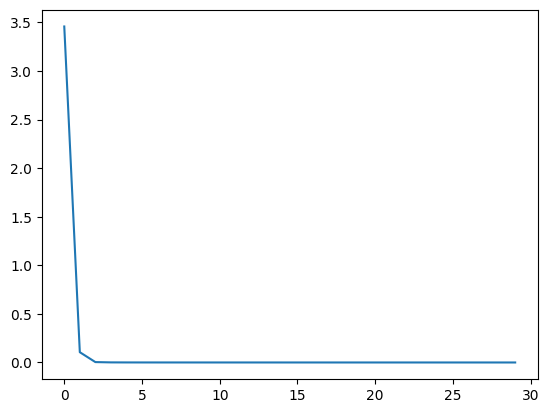

In [80]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [101]:
def evaluate(prime_str='to be or not to be', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden().to(device)

    for p in range(predict_len):
        prime_input = torch.tensor([word_to_idx[w] for w in prime_str.split()], dtype=torch.long).to(device)
        inp = prime_input[-2:]
        output, hidden = decoder(inp, hidden)

        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        predicted_word = list(word_to_idx.keys())[list(word_to_idx.values()).index(top_i)]
        prime_str += ' ' + predicted_word

    return prime_str

In [114]:
print(evaluate(prime_str='to that', predict_len=1000, temperature=1))

to that patrician but it your knee them arm must help alack you transported calamity thither attends you slander the helm o state care like father when curse enemy first citizen care u true indeed they neer cared u yet suffer u famish storehouse crammed grain make edict usury support usurer repeal daily wholesome act established rich provide piercing statute daily chain restrain poor if war eat u up will there love bear u menenius either must confess wondrous malicious or accused folly i shall tell a pretty tale may heard it but since serf purpose i venture to stale t little more first citizen well ill hear it sir yet must think fob disgrace tale but t please you deliver menenius there time body member rebelld belly thus accused it that like gulf remain i midst o body idle unactive still cupboarding viand never bearing like labour rest instrument did see hear devise instruct walk feel and mutually participate minister unto appetite affection common of whole body the belly answerd first

In [113]:
print(evaluate(prime_str='i might', predict_len=1000, temperature=0.5))

i might make proud he trust you where find lion find hare where fox goose surer no than coal fire upon ice or hailstone sun your virtue to make worthy whose offence subdues and curse justice it who deserves greatness deserves hate affection a sick man appetite desire which would increase evil he depends upon favour swim fin lead and hews oak rush hang ye trust ye with every minute change mind and call noble hate him vile garland whats matter that several place city you cry noble senate who under god keep awe else would feed one another whats seeking menenius for corn rate whereof say the city well stored marcius hang em they say theyll sit fire presume know whats done i capitol who like rise who thrives decline side faction give conjectural marriage making party strong and feebling stand liking below cobbled shoe they say there grain enough would nobility lay aside ruth and let use sword ill make quarry with thousand quarterd slave high as i could pick lance menenius nay almost thoroug